# Codelab Introduzione a TensorFlow 2.0 (Norman Di Palo)
## Organizzato da [Italian Association for Machine Learning](http://iaml.it) e [Sourcesense](https://www.sourcesense.com)

In [0]:
!pip install tensorflow-gpu==2.0.0-alpha0

     |████████████████████████████████| 332.1MB 58kB/s 
     |████████████████████████████████| 419kB 36.7MB/s 
     |████████████████████████████████| 61kB 23.8MB/s 
     |████████████████████████████████| 3.0MB 27.3MB/s 


In [0]:
import tensorflow as tf

In [0]:
tf.executing_eagerly() #Check that it's executing eagerly

True

In [0]:
tf.test.is_gpu_available()

True

In [0]:
a = tf.constant(1) #Let's create our first Tensor
a

<tf.Tensor: id=0, shape=(), dtype=int32, numpy=1>

# TensorFlow 2 ❤️ Numpy
TF and Numpy can use their own functions with mixed arguments (Tensors or arrays), giving coherent results.

In [0]:
import numpy as np

In [0]:
b = np.array(3) #create an arrat
b

array(3)

In [0]:
c = tf.add(a, b) #array + Tensor = Tensor
c

<tf.Tensor: id=3, shape=(), dtype=int32, numpy=4>

In [0]:
c = a + b #also like this
c

<tf.Tensor: id=6, shape=(), dtype=int32, numpy=4>

In [0]:
d = np.add(a,b)  #but if we use a numpy op it becomes an array
d

4

In [0]:
c.numpy() #we can take the numpy of a tensor like this

4

# tf.Tensor? tf.Variable!

In [0]:
v = tf.Variable(tf.ones([2, 2])) #when you want to create a stateful object to be manipulated, create a Variable
v

<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[1., 1.],
       [1., 1.]], dtype=float32)>

In [0]:
v = tf.Variable([[1.,1.],[1.,1.]])
v

<tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[1., 1.],
       [1., 1.]], dtype=float32)>

In [0]:
with tf.device("/device:GPU:0"):  #you can place it on selected devices. by default, it goes on the fastest
  faster_v = tf.Variable([[1.,1.],[1.,1.]])
faster_v.device, v.device

('/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:0')

In [0]:
with tf.device("/device:CPU:0"):
  slower_v = tf.Variable([[1.,1.],[1.,1.]])
slower_v.device, v.device

('/job:localhost/replica:0/task:0/device:CPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:0')

In [0]:
(faster_v + slower_v).device  #Many TensorFlow operations are accelerated using the GPU for computation. 
#Without any annotations, TensorFlow automatically decides whether to use the GPU or CPU for an operation copying the tensor between CPU and GPU memory,
#if necessary. Tensors produced by an operation are typically backed by the memory of the device on which the operation executed, for example:

'/job:localhost/replica:0/task:0/device:GPU:0'

In [0]:
tf.config.gpu.set_per_process_memory_growth(False) #Put it at the beginning! Useful for avoiding TF from taking all GPU memory from the beginning
tf.debugging.set_log_device_placement(True)

RuntimeError: ignored

In [0]:
v + 1 #Tensor!

<tf.Tensor: id=52, shape=(2, 2), dtype=float32, numpy=
array([[2., 2.],
       [2., 2.]], dtype=float32)>

In [0]:
u = v + 1
u

<tf.Tensor: id=56, shape=(2, 2), dtype=float32, numpy=
array([[2., 2.],
       [2., 2.]], dtype=float32)>

In [0]:
v.assign_add(tf.ones([2,2]))  #use Variable methods to keep a variable a variable. That's what you will use for optimization (that is internally used by optimizers)

<tf.Variable 'UnreadVariable' shape=(2, 2) dtype=float32, numpy=
array([[2., 2.],
       [2., 2.]], dtype=float32)>

In [0]:
v.trainable

True

In [0]:
# The idea is to use Variables for stuff that we want to store and, probably, optimize.
# Tensors are passed around as values to be manipulated with Variables.
#Tensors are immutable! This comes from TF 1.0.

# Using GradientTape to store gradients
TensorFlow provides the tf.GradientTape API for automatic differentiation - computing the gradient of a computation with respect to its input variables. Tensorflow "records" all operations executed inside the context of a tf.GradientTape onto a "tape"

In [0]:
x = tf.ones((2, 2))

with tf.GradientTape() as t:
  t.watch(x)  #only needed if the variable is NOT a tf.Variable
  y = tf.reduce_sum(x)
  z = tf.multiply(y, y)

# Derivative of z (scalar) with respect to the original input tensor x (matrix)
dz_dx = t.gradient(z, x)
dz_dx

<tf.Tensor: id=77, shape=(2, 2), dtype=float32, numpy=
array([[8., 8.],
       [8., 8.]], dtype=float32)>

In [0]:
dz_dy = t.gradient(z, y)  #can't call it a second time by default. helps preventing errors.

RuntimeError: ignored

In [0]:
"""By default, the resources held by a GradientTape are released as soon as 
GradientTape.gradient() method is called. 
To compute multiple gradients over the same computation, 
create a persistent gradient tape. This allows multiple calls to the gradient() method. 
as resources are released when the tape object is garbage collected."""

x = tf.ones((2, 2))

with tf.GradientTape(persistent = True) as t:
  t.watch(x)  #only needed if the variable is NOT a tf.Variable
  y = tf.reduce_sum(x)
  z = tf.multiply(y, y)

# Derivative of z (scalar) with respect to y (scalar)
dz_dy = t.gradient(z, y)

dz_dx = t.gradient(z, x)

dz_dz = t.gradient(z, z)

dz_dy, dz_dx, dz_dz

(<tf.Tensor: id=88, shape=(), dtype=float32, numpy=8.0>,
 <tf.Tensor: id=100, shape=(2, 2), dtype=float32, numpy=
 array([[8., 8.],
        [8., 8.]], dtype=float32)>,
 <tf.Tensor: id=101, shape=(), dtype=float32, numpy=1.0>)

In [0]:
#Higher Order Gradients!

x = tf.Variable(1.0)  # Create a Tensorflow variable initialized to 1.0

with tf.GradientTape() as t:
  with tf.GradientTape() as t2:
    y = x * x * x
  # Compute the gradient inside the 't' context manager
  # which means the gradient computation is differentiable as well.
  dy_dx = t2.gradient(y, x)
d2y_dx2 = t.gradient(dy_dx, x)

d2y_dx2, dy_dx

(<tf.Tensor: id=144, shape=(), dtype=float32, numpy=6.0>,
 <tf.Tensor: id=129, shape=(), dtype=float32, numpy=3.0>)

# Now we can train a simple model!
We'll create a linear, one input one output model.

In [0]:
w = tf.Variable(2.0)  #a linear model is a very very simple neural network with one neuron and no non-linearity
b = tf.Variable(0.0)

In [0]:
def forward(x):
  return w*x + b

In [0]:
forward(1.)

<tf.Tensor: id=165, shape=(), dtype=float32, numpy=2.0>

In [0]:
def loss(predicted_y, desired_y):  #define a loss with tf operations
  return tf.reduce_mean(tf.square(predicted_y - desired_y))

In [0]:
TRUE_W = 3.0  #generate training data. it's a wavy-line
TRUE_b = 2.0
NUM_EXAMPLES = 1000

inputs  = tf.random.normal(shape=[NUM_EXAMPLES])
noise   = tf.random.normal(shape=[NUM_EXAMPLES])*0.2
outputs = inputs * TRUE_W + TRUE_b + noise + 2.*np.sin(inputs*3.14)

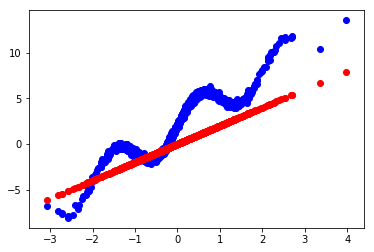

Current loss: 
7.472215


In [0]:
import matplotlib.pyplot as plt

plt.scatter(inputs, outputs, c='b')
plt.scatter(inputs, forward(inputs), c='r')
plt.show()

print('Current loss: '),
print(loss(forward(inputs), outputs).numpy())


In [0]:
def train(inputs, outputs, learning_rate):  #manual training step
  with tf.GradientTape() as t:
    current_loss = loss(forward(inputs), outputs)
  dw, db = t.gradient(current_loss, [w, b])
  w.assign_sub(learning_rate * dw)
  b.assign_sub(learning_rate * db)

In [0]:
epochs = range(10)
for epoch in epochs:

  current_loss = loss(forward(inputs), outputs)

  train(inputs, outputs, learning_rate=0.1)
  print('Epoch {}: loss={}'.format(epoch, current_loss))


Epoch 0: loss=7.472215175628662
Epoch 1: loss=5.510189533233643
Epoch 2: loss=4.262564182281494
Epoch 3: loss=3.469209671020508
Epoch 4: loss=2.9647202491760254
Epoch 5: loss=2.643916606903076
Epoch 6: loss=2.4399166107177734
Epoch 7: loss=2.310192108154297
Epoch 8: loss=2.227698802947998
Epoch 9: loss=2.1752402782440186


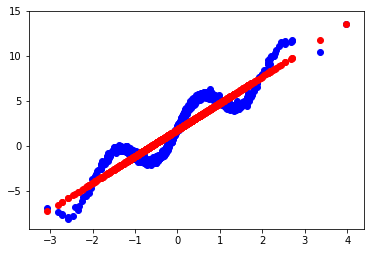

Current loss: 
2.1418808


In [0]:

plt.scatter(inputs, outputs, c='b')
plt.scatter(inputs, forward(inputs), c='r')
plt.show()

print('Current loss: '),
print(loss(forward(inputs), outputs).numpy())


# Let's build neural networks: tf.Keras!
We have three main ways of building a model with tf.Keras: Sequential, Functional, and subclassing.
(by the way, Keras and tf.Keras are not completely the same things)

In [0]:
from tensorflow.keras import layers

In [0]:
model = tf.keras.Sequential([
# Adds a densely-connected layer with 64 units to the model:
layers.Dense(64, activation='relu', input_shape=(1,)),
# Add another:
layers.Dense(64, activation='relu'),
# Add a softmax layer with 10 output units:
layers.Dense(1, activation='linear')])

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mse',
              metrics=['mse'])

In [0]:
model.fit(x = inputs, y = outputs, epochs = 20, validation_split=0.1)

Train on 900 samples, validate on 100 samples
Epoch 1/20
900/900 [==============================] - 1s 1ms/sample - loss: 14.4525 - mse: 14.4525 - val_loss: 11.0058 - val_mse: 11.0058
Epoch 2/20
900/900 [==============================] - 0s 149us/sample - loss: 9.4922 - mse: 9.4922 - val_loss: 6.0062 - val_mse: 6.0062
Epoch 3/20
900/900 [==============================] - 0s 141us/sample - loss: 3.5536 - mse: 3.5536 - val_loss: 2.0814 - val_mse: 2.0814
Epoch 4/20
900/900 [==============================] - 0s 150us/sample - loss: 1.7774 - mse: 1.7774 - val_loss: 1.7804 - val_mse: 1.7804
Epoch 5/20
900/900 [==============================] - 0s 149us/sample - loss: 1.5733 - mse: 1.5733 - val_loss: 1.6532 - val_mse: 1.6532
Epoch 6/20
900/900 [==============================] - 0s 146us/sample - loss: 1.4669 - mse: 1.4669 - val_loss: 1.5320 - val_mse: 1.5320
Epoch 7/20
900/900 [==============================] - 0s 146us/sample - loss: 1.3409 - mse: 1.3409 - val_loss: 1.4042 - val_mse: 1.4042


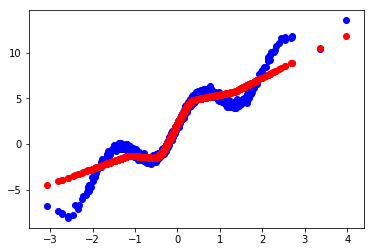

Current loss: 
0.7173335


In [0]:

plt.scatter(inputs, outputs, c='b')
plt.scatter(inputs, model(tf.expand_dims(inputs,1))[:,0], c='r')
plt.show()

print('Current loss: '),
print(loss(model(tf.expand_dims(inputs,1))[:,0], outputs).numpy())


In [0]:
#Functional
#With Functional API, you can treat layers like functions and manipulate the intermediate outputs.
#It gives more flexibility, e.g. I can easily add up two outputs from different layers.
input_x = layers.Input(shape = [1])
x = layers.Dense(64, activation = "relu")(input_x)
x = layers.Dense(64, activation = "relu")(x)
x = layers.Dense(1, activation = "linear")(x)

model = tf.keras.Model(inputs = input_x, outputs = x)

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mse',
              metrics=['mse'])

In [0]:
model.fit(x = inputs, y = outputs, epochs = 50, validation_split=0.1)

Train on 900 samples, validate on 100 samples
Epoch 1/50
900/900 [==============================] - 0s 376us/sample - loss: 14.2832 - mse: 14.2832 - val_loss: 11.1686 - val_mse: 11.1686
Epoch 2/50
900/900 [==============================] - 0s 145us/sample - loss: 9.7815 - mse: 9.7815 - val_loss: 6.5506 - val_mse: 6.5506
Epoch 3/50
900/900 [==============================] - 0s 140us/sample - loss: 4.1033 - mse: 4.1033 - val_loss: 2.3373 - val_mse: 2.3373
Epoch 4/50
900/900 [==============================] - 0s 143us/sample - loss: 1.7395 - mse: 1.7395 - val_loss: 1.7694 - val_mse: 1.7694
Epoch 5/50
900/900 [==============================] - 0s 147us/sample - loss: 1.5790 - mse: 1.5790 - val_loss: 1.6621 - val_mse: 1.6621
Epoch 6/50
900/900 [==============================] - 0s 164us/sample - loss: 1.4855 - mse: 1.4855 - val_loss: 1.5272 - val_mse: 1.5272
Epoch 7/50
900/900 [==============================] - 0s 160us/sample - loss: 1.3702 - mse: 1.3702 - val_loss: 1.4413 - val_mse: 1.441

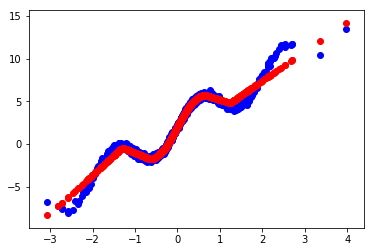

Current loss: 
0.24781765


In [0]:

plt.scatter(inputs, outputs, c='b')
plt.scatter(inputs, model(tf.expand_dims(inputs,1))[:,0], c='r')
plt.show()

print('Current loss: '),
print(loss(model(tf.expand_dims(inputs,1))[:,0], outputs).numpy())


In [0]:
#Subclassing
#This is the most flexible method. You ineherit the tf.keras.Model and its functions.
# From great flexibility comes great responsibility!
class Model(tf.keras.Model):

  def __init__(self):
    super(Model, self).__init__(name='my_model')
    # Define your layers here.
    self.dense_1 = layers.Dense(64, activation='relu')
    self.dense_2 = layers.Dense(64, activation='relu')
    self.dense_3 = layers.Dense(1, activation='linear')

  def call(self, inputs):
    # Define your forward pass here,
    # using layers you previously defined (in `__init__`).
    x = self.dense_1(inputs)
    x = self.dense_2(x)
    return self.dense_3(x)

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mse',
              metrics=['mse'])

In [0]:
model.fit(x = inputs, y = outputs, epochs = 50, validation_split=0.1)

Train on 900 samples, validate on 100 samples
Epoch 1/50
900/900 [==============================] - 0s 382us/sample - loss: 0.2604 - mse: 0.2604 - val_loss: 0.1149 - val_mse: 0.1149
Epoch 2/50
900/900 [==============================] - 0s 154us/sample - loss: 0.2540 - mse: 0.2539 - val_loss: 0.0995 - val_mse: 0.0995
Epoch 3/50
900/900 [==============================] - 0s 142us/sample - loss: 0.2440 - mse: 0.2440 - val_loss: 0.0890 - val_mse: 0.0890
Epoch 4/50
900/900 [==============================] - 0s 142us/sample - loss: 0.2309 - mse: 0.2309 - val_loss: 0.0954 - val_mse: 0.0954
Epoch 5/50
900/900 [==============================] - 0s 130us/sample - loss: 0.2273 - mse: 0.2273 - val_loss: 0.0920 - val_mse: 0.0920
Epoch 6/50
900/900 [==============================] - 0s 145us/sample - loss: 0.2240 - mse: 0.2240 - val_loss: 0.0893 - val_mse: 0.0893
Epoch 7/50
900/900 [==============================] - 0s 147us/sample - loss: 0.2110 - mse: 0.2110 - val_loss: 0.0826 - val_mse: 0.0826
Ep

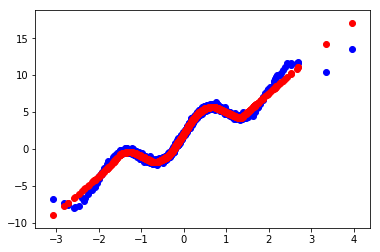

Current loss: 
0.13837492


In [0]:

plt.scatter(inputs, outputs, c='b')
plt.scatter(inputs, model(tf.expand_dims(inputs,1))[:,0], c='r')
plt.show()

print('Current loss: '),
print(loss(model(tf.expand_dims(inputs,1))[:,0], outputs).numpy())


In [0]:
model.save('my_model.h5')
model = tf.keras.models.load_model('my_model.h5')

# The best way to use data: tf.data!
GPUs and TPUs can radically reduce the time required to execute a single training step. Achieving peak performance requires an efficient input pipeline that delivers data for the next step before the current step has finished. The tf.data API helps to build flexible and efficient input pipelines. 
**extract, transform, load!**

In [0]:
#Let's reuse our previous 1 dim dataset.
ds = tf.data.Dataset.from_tensor_slices((inputs, outputs)) #this creates a dataset from something you have in memory 

In [0]:
ds = tf.data.Dataset.from_tensor_slices((inputs, outputs))
for i,x in enumerate(ds): #you can easility iterate over a ds
  print(x)
  if i == 10: break

(<tf.Tensor: id=36535, shape=(), dtype=float32, numpy=1.3043398>, <tf.Tensor: id=36536, shape=(), dtype=float32, numpy=4.154091>)
(<tf.Tensor: id=36539, shape=(), dtype=float32, numpy=-0.22936687>, <tf.Tensor: id=36540, shape=(), dtype=float32, numpy=-0.09245944>)
(<tf.Tensor: id=36543, shape=(), dtype=float32, numpy=-0.4710796>, <tf.Tensor: id=36544, shape=(), dtype=float32, numpy=-1.6305478>)
(<tf.Tensor: id=36547, shape=(), dtype=float32, numpy=1.6474373>, <tf.Tensor: id=36548, shape=(), dtype=float32, numpy=5.298766>)
(<tf.Tensor: id=36551, shape=(), dtype=float32, numpy=0.8048115>, <tf.Tensor: id=36552, shape=(), dtype=float32, numpy=5.739079>)
(<tf.Tensor: id=36555, shape=(), dtype=float32, numpy=0.46111974>, <tf.Tensor: id=36556, shape=(), dtype=float32, numpy=5.196908>)
(<tf.Tensor: id=36559, shape=(), dtype=float32, numpy=0.7493753>, <tf.Tensor: id=36560, shape=(), dtype=float32, numpy=5.475157>)
(<tf.Tensor: id=36563, shape=(), dtype=float32, numpy=-2.1016119>, <tf.Tensor: id

In [0]:
BATCH_SIZE = 32

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = ds.shuffle(buffer_size=1000)  #shuffle samples
ds = ds.repeat()  #repeat the dataset as many times as you need
ds = ds.batch(BATCH_SIZE) #create automatic batches
ds

<BatchDataset shapes: ((None,), (None,)), types: (tf.float32, tf.float32)>

In [0]:
for i,x in enumerate(ds): #notice what is returned now
  print(x)
  if i == 10: break

(<tf.Tensor: id=36593, shape=(32,), dtype=float32, numpy=
array([-1.4954041 ,  0.2737211 ,  0.92272985,  1.0796163 , -0.3038552 ,
        2.7022302 ,  0.9397919 , -0.5628733 ,  0.2001949 , -1.1551175 ,
       -0.42486724,  1.202832  ,  0.84019405,  0.24745388,  2.1839805 ,
       -0.21479815,  0.39158386,  0.18983041, -0.00479852, -0.33981428,
        0.39037517, -0.97837037, -1.2050459 , -2.5697887 , -0.5760138 ,
        0.38992897,  2.1813922 , -1.0479114 , -0.28980798, -1.1170349 ,
        0.34043756,  0.47270745], dtype=float32)>, <tf.Tensor: id=36594, shape=(32,), dtype=float32, numpy=
array([-0.45522773,  4.4359126 ,  5.2044635 ,  4.7002406 , -0.36072183,
       11.687289  ,  4.9814444 , -1.6080841 ,  3.8158092 , -0.60129243,
       -1.4488826 ,  4.398058  ,  5.6029844 ,  4.3268604 ,  9.702735  ,
       -0.07654488,  5.0001354 ,  3.8356853 ,  2.071216  , -0.9675334 ,
        5.135659  , -0.9077087 ,  0.01730704, -7.8277836 , -1.7038734 ,
        5.062771  ,  9.777052  , -1.015834

In [0]:
#Let's use an image dataset

In [0]:
import pathlib
data_root_orig = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True) #download the dataset of flowers
data_root = pathlib.Path(data_root_orig)

import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)  #store all paths and shuffle them

228818944/228813984 [==============================] - 2s 0us/step


In [0]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_to_index = dict((name, index) for index,name in enumerate(label_names))
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] 
                    for path in all_image_paths] #get labels to classify them

def load_and_preprocess_image(path):  #load image using tensorflow function and preprocess it
  image = tf.io.read_file(path)
  return preprocess_image(image)

def preprocess_image(image):  #preprocess by decoding and resizing it
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [192, 192])
  image /= 255.0  # normalize to [0,1] range

  return image

In [0]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths) #all the images won't probably fit in memory, but the paths will,
path_ds                                                       # and you can use the same method to create a dataset!

<TensorSliceDataset shapes: (), types: tf.string>

In [0]:
image_ds = path_ds.map(load_and_preprocess_image) #big difference: the map method applied the given function to each sample. Our function also loads the data, going from path to actual image!


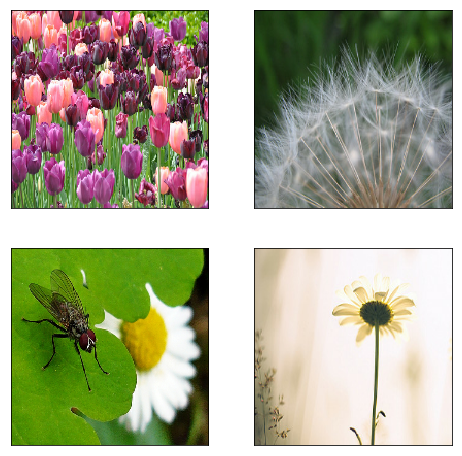

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n,image in enumerate(image_ds.take(4)):
  plt.subplot(2,2,n+1)
  plt.imshow(image)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])


In [0]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))


In [0]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))  #we can create the full X,y dataset by zipping two datasets...


In [0]:
#An alternative!
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels)) #... or creating it with a tuple of arrays!

# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<MapDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>

In [0]:
BATCH_SIZE = 32

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = image_label_ds.shuffle(buffer_size=3000)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
ds = ds.prefetch(5)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

# The best of both worlds: tf.function and AutoGraph

In [0]:
"""TF 2.0 brings together the ease of eager execution and the power of TF 1.0. At the center of this merger is tf.function, 
which allows you to transform a subset of Python syntax into portable, high-performance TensorFlow graphs."""

from tensorflow.python.ops import control_flow_util
control_flow_util.ENABLE_CONTROL_FLOW_V2 = True

In [0]:
def add(a, b):
  return a + b

add(tf.ones([2, 2]), tf.ones([2, 2]))  #  [[2., 2.], [2., 2.]]
add #this is a normal python function

<function __main__.add>

In [0]:
@tf.function
def add(a, b):
  return a + b

add(tf.ones([2, 2]), tf.ones([2, 2]))  #  [[2., 2.], [2., 2.]]
add #this is now something else!

In [0]:
def linear_layer(x):
  return 2 * x + 1


@tf.function #if your decorated function has other functions inside, they get automatically compiled
def deep_net(x):
  return tf.nn.relu(linear_layer(x))


deep_net(tf.constant((1, 2, 3)))

<tf.Tensor: id=36737, shape=(3,), dtype=int32, numpy=array([3, 5, 7], dtype=int32)>

In [0]:
@tf.function
def add(a, b):
  return a + b

v = tf.Variable(1.0)
with tf.GradientTape() as tape:  #you can also compute gradients
  result = add(v, 1.0)
tape.gradient(result, v)

<tf.Tensor: id=36766, shape=(), dtype=float32, numpy=1.0>

In [0]:
@tf.function  #control flow like ifs and whiles works like a charm.
def sum_even(items):
  s = 0
  for c in items:
    if c % 2 > 0:
      continue
    s += c
  return s


sum_even(tf.constant([10, 12, 15, 20]))

<tf.Tensor: id=36850, shape=(), dtype=int32, numpy=42>

In [0]:
print(tf.autograph.to_code(sum_even.python_function, experimental_optional_features=None)) #autograph basically "compiles" python code to tensorflow code.

from __future__ import print_function

def tf__sum_even(items):
  do_return = False
  retval_ = None
  s = 0

  def loop_body(loop_vars, s_2):
    c = loop_vars
    continue_ = False
    cond = c % 2 > 0

    def if_true():
      continue_ = True
      return continue_

    def if_false():
      return continue_
    continue_ = ag__.if_stmt(cond, if_true, if_false)
    cond_1 = ag__.not_(continue_)

    def if_true_1():
      s_1, = s_2,
      s_1 += c
      return s_1

    def if_false_1():
      return s_2
    s_2 = ag__.if_stmt(cond_1, if_true_1, if_false_1)
    return s_2,
  s, = ag__.for_stmt(items, None, loop_body, (s,))
  do_return = True
  retval_ = s
  return retval_



tf__sum_even.autograph_info__ = {}



In [0]:
# Functions can be faster than eager code, for graphs with many small ops

import timeit
conv_layer = tf.keras.layers.Conv2D(100, 3)

@tf.function
def conv_fn(image):
  return conv_layer(image)

image = tf.zeros([1, 200, 200, 100])
# warm up
conv_layer(image); conv_fn(image)
print("Eager conv:", timeit.timeit(lambda: conv_layer(image), number=10))
print("Function conv:", timeit.timeit(lambda: conv_fn(image), number=10))
print("Note how there's not much difference in performance for convolutions")

lstm_cell = tf.keras.layers.LSTMCell(10)

@tf.function
def lstm_fn(input, state):
  return lstm_cell(input, state)

input = tf.zeros([10, 10])
state = [tf.zeros([10, 10])] * 2
# warm up
lstm_cell(input, state); lstm_fn(input, state)
print("eager lstm:", timeit.timeit(lambda: lstm_cell(input, state), number=10))
print("function lstm:", timeit.timeit(lambda: lstm_fn(input, state), number=10))

Eager conv: 0.005322732000081487
Function conv: 0.0038140970000313246
Note how there's not much difference in performance for convolutions
eager lstm: 0.08961009500001182
function lstm: 0.00763737600004788


In [0]:
class CustomModel(tf.keras.models.Model):

  @tf.function  #Highly suggested to use it in yours models as well!
  def call(self, input_data):
    if tf.reduce_mean(input_data) > 0:
      return input_data
    else:
      return input_data // 2


model = CustomModel()

model(tf.constant([-2, -4]))

<tf.Tensor: id=42767, shape=(2,), dtype=int32, numpy=array([-1, -2], dtype=int32)>

# A full example: Eager + Keras + GradientTape + Data + Autograph!

In [0]:
from tensorflow.python.ops import control_flow_util
control_flow_util.ENABLE_CONTROL_FLOW_V2 = True

In [0]:
def prepare_mnist_features_and_labels(x, y):
  x = tf.cast(x, tf.float32) / 255.0
  y = tf.cast(y, tf.int64)
  return x, y

def mnist_dataset():
  (x, y), _ = tf.keras.datasets.mnist.load_data()
  ds = tf.data.Dataset.from_tensor_slices((x, y))
  ds = ds.map(prepare_mnist_features_and_labels)
  ds = ds.take(20000).shuffle(20000).batch(100)
  return ds

train_dataset = mnist_dataset()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
with tf.device("/device:CPU:0"):
  model = tf.keras.Sequential((
      tf.keras.layers.Reshape(target_shape=(28 * 28,), input_shape=(28, 28)),
      tf.keras.layers.Dense(100, activation='relu'),
      tf.keras.layers.Dense(100, activation='relu'),
      tf.keras.layers.Dense(10)))
  model.build()
  optimizer = tf.keras.optimizers.Adam()

In [0]:
with tf.device("/device:CPU:0"):

  compute_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

  compute_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()


  def train_one_step(model, optimizer, x, y):
    with tf.GradientTape() as tape:
      logits = model(x)
      loss = compute_loss(y, logits)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    compute_accuracy(y, logits)
    return loss


  @tf.function
  def train(model, optimizer):
    train_ds = mnist_dataset()
    step = 0
    loss = 0.0
    accuracy = 0.0
    for x, y in train_ds:
      step += 1
      loss = train_one_step(model, optimizer, x, y)
      if tf.equal(step % 10, 0):
        tf.print('Step', step, ': loss', loss, '; accuracy', compute_accuracy.result())
    return step, loss, accuracy

  step, loss, accuracy = train(model, optimizer)
  print('Final step', step, ': loss', loss, '; accuracy', compute_accuracy.result())

Step 10 : loss 1.80742872 ; accuracy 0.316
Step 20 : loss 1.07904613 ; accuracy 0.4735
Step 30 : loss 0.665736556 ; accuracy 0.574
Step 40 : loss 0.694476485 ; accuracy 0.6365
Step 50 : loss 0.488440335 ; accuracy 0.6786
Step 60 : loss 0.38866654 ; accuracy 0.711333334
Step 70 : loss 0.45918861 ; accuracy 0.733285725
Step 80 : loss 0.647508323 ; accuracy 0.749875
Step 90 : loss 0.502687097 ; accuracy 0.766
Step 100 : loss 0.32553044 ; accuracy 0.7785
Step 110 : loss 0.350531161 ; accuracy 0.789181828
Step 120 : loss 0.35478887 ; accuracy 0.798583329
Step 130 : loss 0.303538203 ; accuracy 0.805692315
Step 140 : loss 0.316571444 ; accuracy 0.812285721
Step 150 : loss 0.23554264 ; accuracy 0.8186
Step 160 : loss 0.299467206 ; accuracy 0.825062513
Step 170 : loss 0.341586262 ; accuracy 0.829882324
Step 180 : loss 0.267549604 ; accuracy 0.835888863
Step 190 : loss 0.398835599 ; accuracy 0.840263128
Step 200 : loss 0.543105423 ; accuracy 0.8439
Final step tf.Tensor(200, shape=(), dtype=int32